# Master's Thesis DSS: Bile Acid Based Alzheimer's Disease Prediction 
## - Shadi Saee - 
## Exploratory Data Analysis

## Load Libraries and Data

In [1]:
import os
import numpy as np
import pandas as pd
import scipy as sc
import sklearn as sk
import seaborn as sns
import scipy.stats as stats

%matplotlib inline 
import matplotlib.pyplot as plt 
plt.rcParams["font.family"] = "Times New Roman"  #global settings for font in plots


from math import sqrt
from statistics import mean, stdev, variance


from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [294]:
mcibl = pd.read_csv("Data/MCIBL.csv")
mcibl = mcibl.drop(mcibl.columns[[0]], axis = 1)

preds = mcibl.drop(["CONVERT", "RID"], axis = 1)
ba = mcibl.loc[:,["CA_CDCA", "DCA_CA","GLCA_CDCA", "GDCA_CA","GDCA_DCA", "TDCA_CA", "TLCA_CDCA", "TDCA_DCA"]]
y = mcibl.loc[:,"CONVERT"]

numerical = mcibl.select_dtypes(include = ["float64", "int"])
numerical = numerical.pop("RID")

## Create train test split

In [295]:
mci_full_train, mci_full_test, mci_y_train, mci_y_test = train_test_split(preds, y, test_size = 0.15,
                                                                          shuffle = True, random_state = 7)

## Count and impute missing values based on train set/test set mean

In [296]:
train_na = mci_full_train.isnull().sum()[mci_full_train.isnull().sum() > 0]
test_na = mci_full_test.isnull().sum()[mci_full_test.isnull().sum() > 0]

In [297]:
train_na

ADAS13    3
dtype: int64

In [298]:
test_na

Series([], dtype: int64)

In [299]:
# Impute three missing values in ADAS13 column with the mean value
adas13_mean = mci_full_train["ADAS13"].mean()
mci_full_train = mci_full_train.fillna(adas13_mean)

## Subset male and female train/test sets

In [10]:
fem_train_index = mci_full_train["SEX"] == 0
fem_test_index = mci_full_test["SEX"] == 0

male_train_index = mci_full_train["SEX"] == 1
male_test_index = mci_full_test["SEX"] == 1

In [11]:
fem_train_index = mci_full_train["SEX"] == "Female"
fem_test_index = mci_full_test["SEX"] == "Female"

male_train_index = mci_full_train["SEX"] == "Male"
male_test_index = mci_full_test["SEX"] == "Male"

In [12]:
def make_male(df, index):
    male = df[index]
    if isinstance(male, pd.DataFrame):
        male = male.drop("SEX", axis = 1)
    return male

def make_female(df, index):
    female = df[index]
    if isinstance(female, pd.DataFrame):
        female = female.drop("SEX",axis = 1)
    return female 

In [13]:
fem_full_train = make_female(mci_full_train, fem_train_index)
fem_full_test = make_female(mci_full_test, fem_test_index)
fem_y_train = make_female(mci_y_train, fem_train_index)
fem_y_test = make_female(mci_y_test, fem_test_index)

In [14]:
male_full_train = make_male(mci_full_train, male_train_index)
male_full_test = make_male(mci_full_test, male_test_index)
male_y_train = make_male(mci_y_train, male_train_index)
male_y_test = make_male(mci_y_test, male_test_index)

In [15]:
print("Male train set size: {}\nMale test set size: {} \n".format(male_full_train.shape,male_full_test.shape))
print("Female train set size: {}\nFemale test set size: {}".format(fem_full_train.shape, fem_full_test.shape))

Male train set size: (304, 13)
Male test set size: (61, 13) 

Female train set size: (213, 13)
Female test set size: (31, 13)


## Visual inspection of dataset: 
### Histogram of MCI Converters vs. Non-Converters in Men vs. Women

In [110]:
strat_count = pd.crosstab(mcibl.SEX, mcibl.CONVERT)

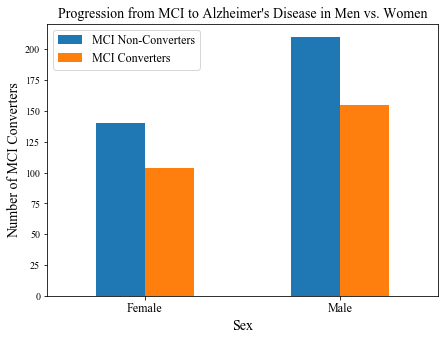

In [118]:
strat_count.plot(kind = "bar", figsize = (7, 5))
plt.title("Progression from MCI to Alzheimer's Disease in Men vs. Women", fontsize = 14)
plt.xlabel('Sex', fontsize = 14)
plt.ylabel('Number of MCI Converters', fontsize = 14)
plt.legend(labels = ["MCI Non-Converters", "MCI Converters"], loc = "best", fontsize = 12)
plt.xticks(rotation = "horizontal", fontsize = 12)
plt.savefig('Conversion by Gender')

### Plot proportion of MCI-Converters in Men vs. Women

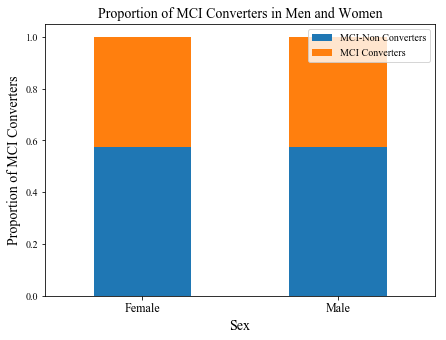

In [143]:
table = strat_count
table.div(table.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True, figsize = (7, 5))

plt.title("Proportion of MCI Converters in Men and Women", fontsize = 14)
plt.xlabel('Sex', fontsize = 14)
plt.ylabel('Proportion of MCI Converters', fontsize = 14)
plt.legend(labels = ["MCI-Non Converters", "MCI Converters"])
plt.xticks(rotation = "horizontal", fontsize = 12)

plt.savefig('Conversion Proportion by Gender')

### Plot Grouped Boxplots of variables split by Conversion status and Sex

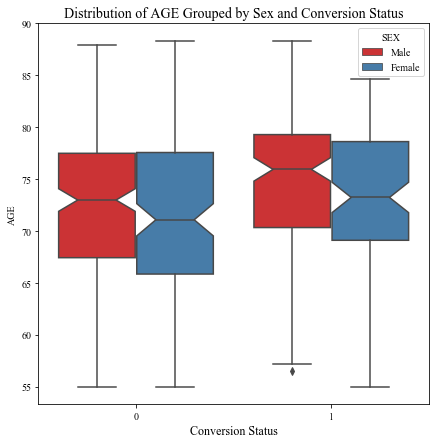

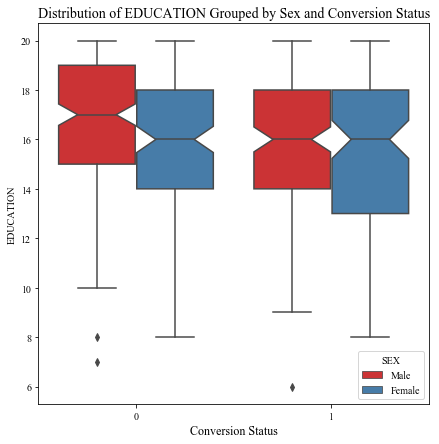

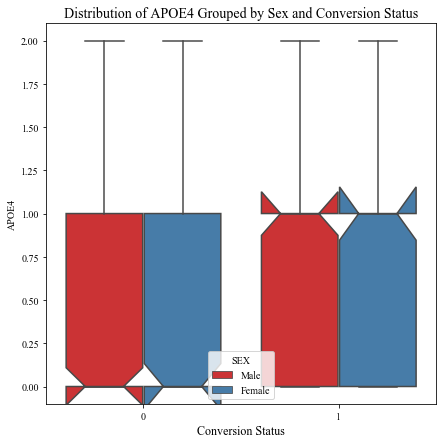

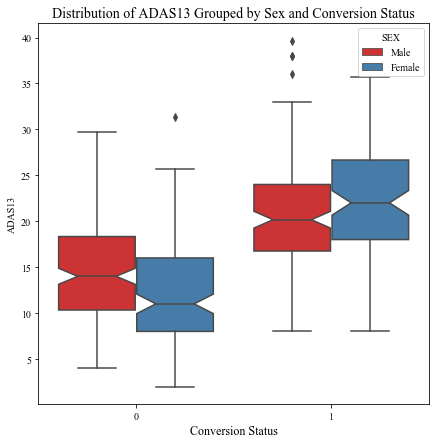

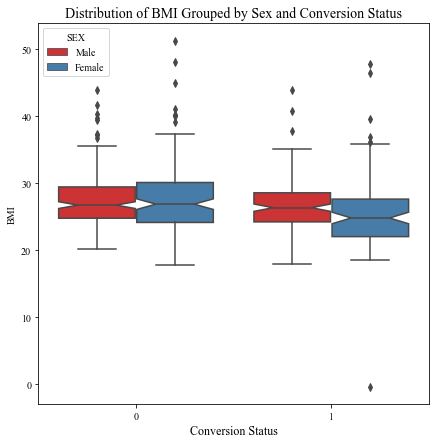

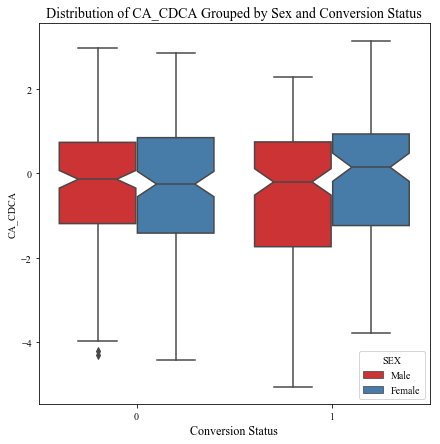

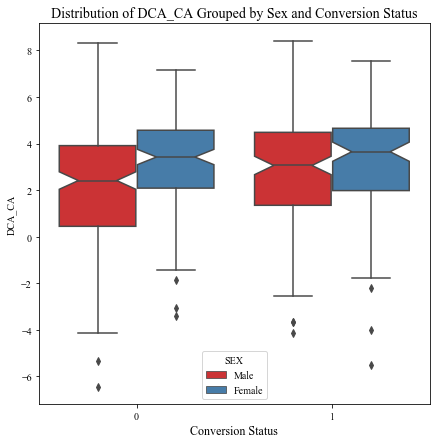

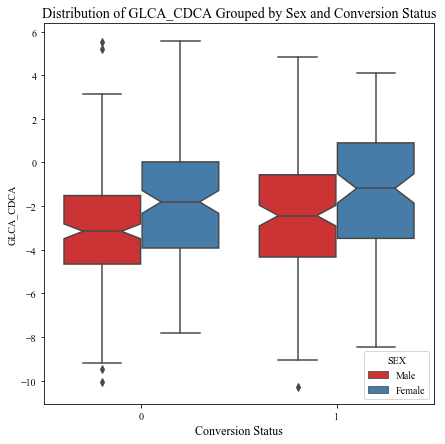

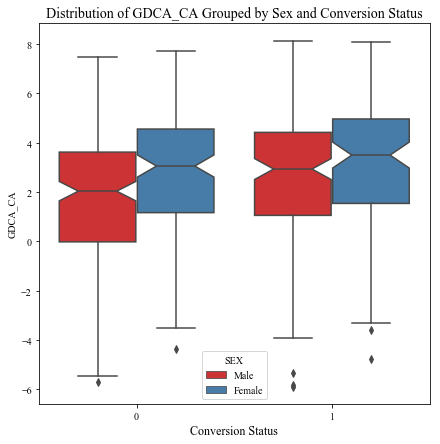

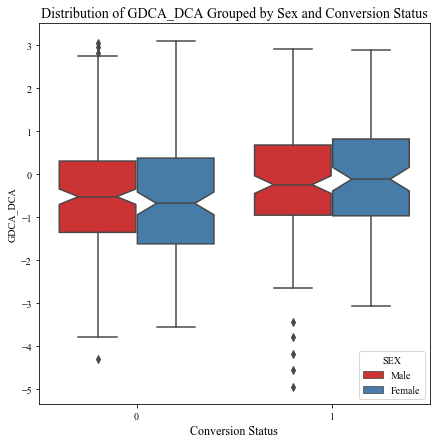

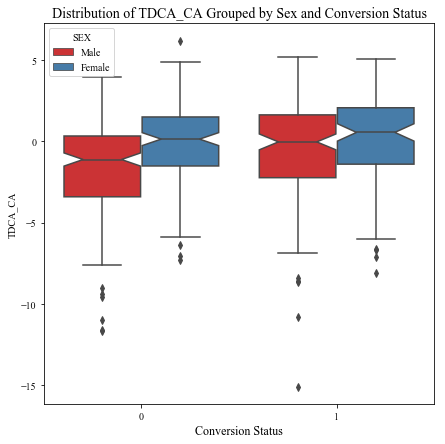

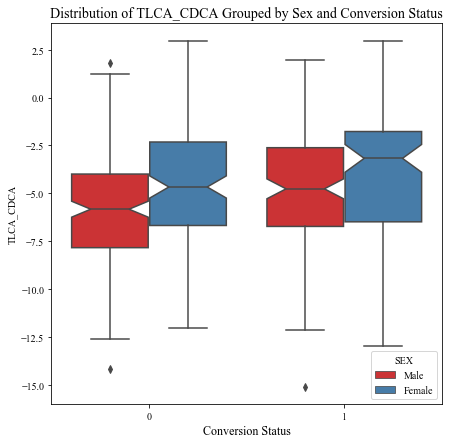

In [153]:
preds2 = mcibl.loc[:,["AGE","EDUCATION","APOE4","ADAS13","BMI","CA_CDCA", "DCA_CA","GLCA_CDCA", "GDCA_CA",
                          "GDCA_DCA", "TDCA_CA", "TLCA_CDCA", "TDCA_DCA"]]
for col in preds2:
    plt.figure(figsize = (7, 7))
    sns.boxplot(x = "CONVERT", y = col, hue = "SEX", data = mcibl, notch  = True, 
                palette = "Set1").set_title( "Distribution of " + str(col) + ' Grouped by Sex and Conversion Status',
                                           fontsize = 14)
    plt.xlabel('Conversion Status', fontsize = 12)
    plt.savefig("Distribution of " + str(col) + ' by Sex and Conversion status')
plt.close()

## Quantitative inspection of dataset
### Calcuate odds ratio of progression to AD for men vs. women

In [129]:
oddsratio, pvalue = stats.fisher_exact(strat_count)
print("OddsR: ", oddsratio, "p-Value:", pvalue)

OddsR:  0.9935897435897436 p-Value: 1.0


### Calculate summary statistics grouped by conversion status and sex

In [130]:
# Calculate group means and standard deviations grouped by conversion status and sex
strat_means = mcibl.drop("RID", axis = 1).groupby(["CONVERT","SEX"]).mean()
strat_means = pd.concat([strat_means], keys = ["Mean"], names = ["Mean"]).transpose()

strat_std = mcibl.drop("RID", axis = 1).groupby(["CONVERT","SEX"]).std()
strat_std = pd.concat([strat_std], keys = ['Standard Dev.'], names = ["Standard Dev."]).transpose()

In [231]:
# Calculate Effect size (Cohen's D) per column
continous_preds = full_train.loc[:,["AGE","EDUCATION","APOE4","ADAS13","BMI","CA_CDCA", "DCA_CA","GLCA_CDCA", "GDCA_CA",
                          "GDCA_DCA", "TDCA_CA", "TLCA_CDCA", "TDCA_DCA"]]

n_fem0 = strat_count[0]["Female"]
n_fem1 = strat_count[1]["Female"]
n_male0 = strat_count[0]["Male"]
n_male1 = strat_count[1]["Male"]

nonconvert_cohens_d = {}
convert_cohens_d = {}

for col in continous_preds:
    col0_fem = mcibl[(mcibl.CONVERT == 0) & (mcibl.SEX == "Female")][col]
    col1_fem = mcibl[(mcibl.CONVERT == 1) & (mcibl.SEX == "Female")][col]
    
    col0_male = mcibl[(mcibl.CONVERT == 0) & (mcibl.SEX == "Male")][col]
    col1_male = mcibl[(mcibl.CONVERT == 1) & (mcibl.SEX == "Male")][col]
    

    s0_fem, s1_fem = variance(col0_fem), variance(col1_fem)
    s0_male, s1_male = variance(col0_male), variance(col1_male)
    
    nonconvert_cohens_d[col] = (mean(col0_fem) - mean(col0_male)) / (sqrt(((n_fem0 - 1) * s0_fem + (n_male0 - 1) * 
                                                                           s0_male) / (n_fem0 + n_male0 - 2)))
    convert_cohens_d[col] = (mean(col1_fem) - mean(col1_male)) / (sqrt(((n_fem1 - 1) * s1_fem + (n_male1 - 1) * 
                                                                           s1_male) / (n_fem1 + n_male1 - 2)))
    

cohensd_df1 = pd.DataFrame([nonconvert_cohens_d, convert_cohens_d]).transpose()
cohensd_df1.columns = ["Effect Size Non-Converters", "Effect Size Converters"]

In [232]:
# Merge group means data frame and effect size data frame 
frames = [strat_means,strat_std, cohensd_df1]
result = pd.concat(frames, axis = 1, sort = False).round(2) 

result.to_excel("Group Means.xlsx")
result.head()

,"(Mean, 0, Female)","(Mean, 0, Male)","(Mean, 1, Female)","(Mean, 1, Male)","(Standard Dev., 0, Female)","(Standard Dev., 0, Male)","(Standard Dev., 1, Female)","(Standard Dev., 1, Male)",Effect Size Non-Converters,Effect Size Converters
AGE,71.50,72.44,72.64,74.79,7.84,7.43,7.27,6.79,-0.12,-0.31
EDUCATION,15.82,16.57,15.22,16.21,2.53,2.80,2.77,2.68,-0.28,-0.37
APOE4,0.42,0.50,0.89,0.83,0.61,0.64,0.68,0.68,-0.13,0.10
ADAS13,12.09,14.69,22.21,20.93,5.75,5.50,5.72,6.02,NaN,NaN
BMI,27.60,27.59,25.56,26.74,5.60,4.19,6.04,3.77,0.00,-0.25


### Plot Probability Densitity plots of distribution of numerical variables

/Users/shadisaee/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/shadisaee/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


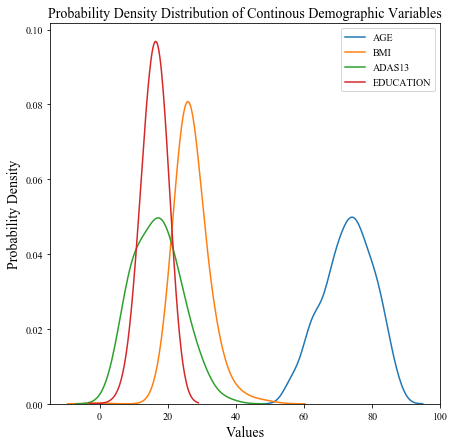

In [168]:
# Plot distribution of demographic continuous variables: 
plt.figure(figsize = (7, 7))
plt.xlabel('Values', fontsize = 14)
plt.ylabel('Probability Density', fontsize = 14)
with sns.color_palette():
    p1=sns.kdeplot(mcibl["AGE"])
    p1=sns.kdeplot(mcibl["BMI"], bw = 3)
    p1=sns.kdeplot(mcibl["ADAS13"], bw = 3)
    p1=sns.kdeplot(mcibl["EDUCATION"], bw = 3).set_title("Probability Density Distribution of Continous Demographic Variables", fontsize = 14)

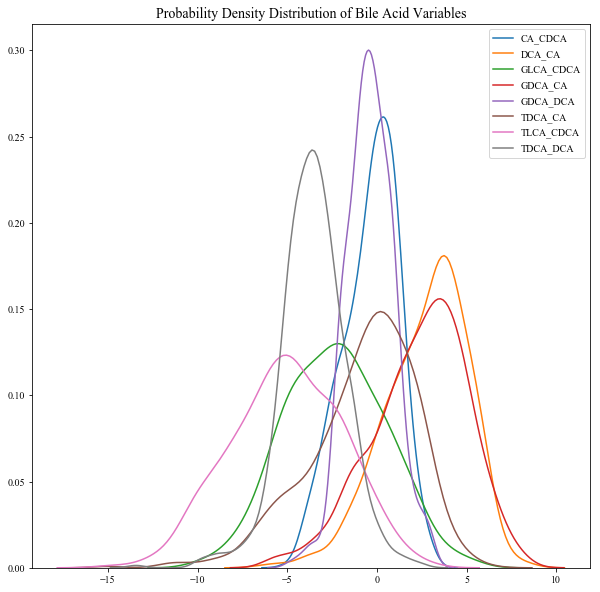

In [167]:
#Plot distribution of bile acid variables
plt.figure(figsize = (10, 10))
plt.title("Probability Density Distribution of Bile Acid Variables", fontsize = 14)
for col in ba:
    sns.kdeplot(mcibl[col])

## Convert Sex variable values to numerical for further processing

In [303]:
le = preprocessing.LabelEncoder()

le.fit(mcibl["SEX"])
class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Mapping:", class_mapping)

preds["SEX"] = le.fit_transform(preds["SEX"])

le.fit(mci_full_train["SEX"])
mci_full_train.loc[:,"SEX"] = le.transform(mci_full_train["SEX"])

# Mapping dictionary source: https://stackoverflow.com/questions/42196589/any-way-to-get-mappings-of-a-label-encoder-in-python-pandas/42889046

Mapping: {'Female': 0, 'Male': 1}


In [290]:
mci_full_train.head()

,AGE,SEX,EDUCATION,APOE4,ADAS13,BMI,CA_CDCA,DCA_CA,GLCA_CDCA,GDCA_CA,GDCA_DCA,TDCA_CA,TLCA_CDCA,TDCA_DCA
530,72.3,0,12,1,11.00,33.088254,-1.980310,4.204510,-5.01493,3.203390,-1.001120,0.117807,-7.47380,-4.08670
378,71.6,0,13,0,17.00,29.750567,-1.791990,2.634640,-4.16716,0.866981,-1.767660,-1.577920,-8.18772,-4.21256
513,65.7,1,20,0,19.00,32.333727,0.733900,4.303790,-0.53144,5.012640,0.708846,2.256000,-1.33510,-2.04779
277,77.6,0,16,1,29.67,30.462905,0.958804,-2.204450,-7.12686,-3.597370,-1.392910,-7.132700,-9.71183,-4.92825
385,74.0,1,20,0,9.00,23.488436,0.994336,0.234247,-4.46849,-0.834051,-1.068300,-3.492500,-7.21617,-3.72674


### Plot Correlation Matrix for Male, Female, and mixed datasets

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5]), <a list of 16 Text xticklabel objects>)

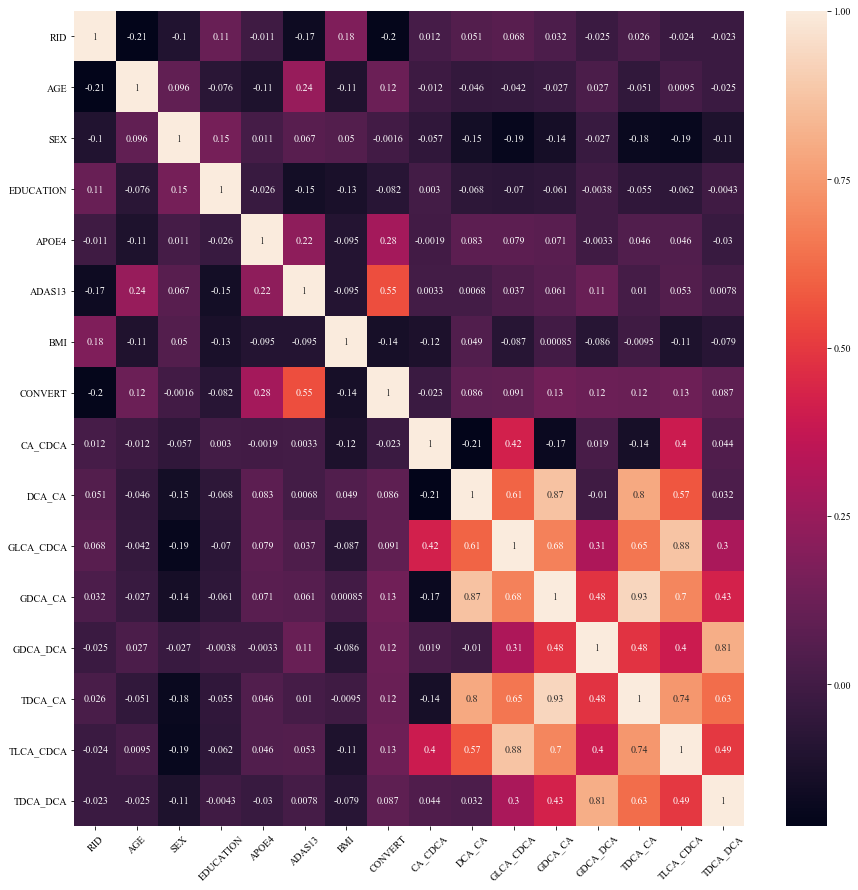

In [236]:
# Mixed dataset corrplot
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(mcibl.corr(), annot = True, ax = ax) 
           # vmin= -.1, vmax = 1, center = 0,
            #cmap=sns.diverging_palette(20, 220, n = 200))
plt.xticks(rotation = 45)

### Female dataset correlation matrix

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]), <a list of 15 Text xticklabel objects>)

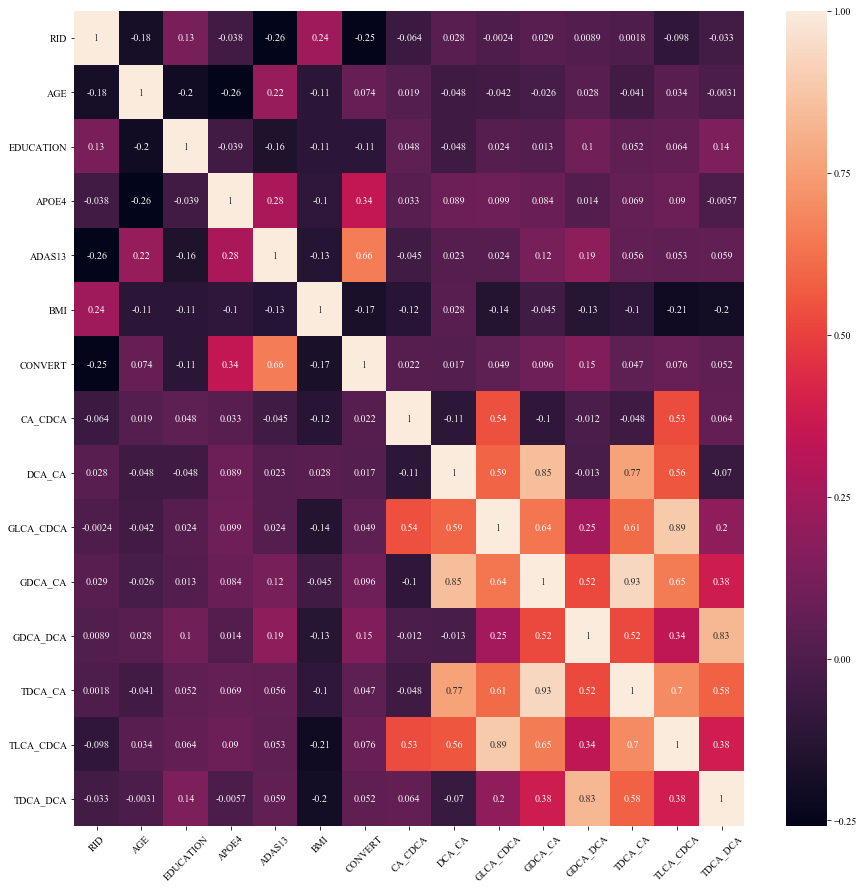

In [241]:
mci_fem = mcibl[mcibl["SEX"] == 0]
mci_fem.pop("SEX")

fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(mci_fem.corr(), annot = True, ax = ax) 
plt.xticks(rotation = 45)

### Male dataset correlation matrix

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]), <a list of 15 Text xticklabel objects>)

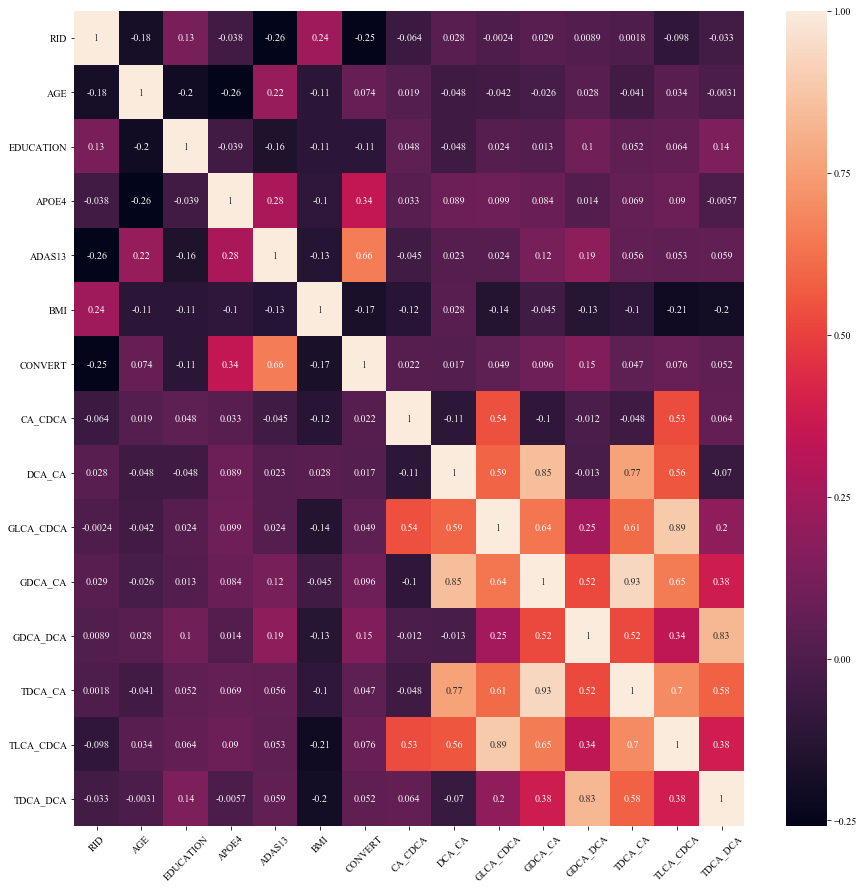

In [242]:
mci_male = mcibl[mcibl["SEX"] == 1]
mci_male.pop("SEX")

fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(mci_fem.corr(), annot = True, ax = ax) 
plt.xticks(rotation = 45)

In [267]:
### Scaling numerical variables

In [305]:
# Scaling numerical values 
scaler = preprocessing.StandardScaler()
scaled_preds = scaler.fit_transform(mci_full_train)
preds = pd.DataFrame(scaled_preds, columns = preds.columns)
preds.head()

,AGE,SEX,EDUCATION,APOE4,ADAS13,BMI,CA_CDCA,DCA_CA,GLCA_CDCA,GDCA_CA,GDCA_DCA,TDCA_CA,TLCA_CDCA,TDCA_DCA
0,-0.058414,-1.194667,-1.468866,0.530698,-0.842810,1.254586,-1.053920,0.631285,-0.954569,0.329736,-0.469662,0.320051,-0.782885,-0.298908
1,-0.152916,-1.194667,-1.104469,-0.960448,0.034533,0.564410,-0.932773,-0.048288,-0.656256,-0.566621,-1.070844,-0.261002,-1.012222,-0.370663
2,-0.949430,0.837053,1.446311,-0.960448,0.326981,1.098563,0.692145,0.674262,0.623081,1.023849,0.871431,1.052719,1.189086,0.863512
3,0.657099,-1.194667,-0.011277,0.530698,1.887190,0.711710,0.836827,-2.143058,-1.697715,-2.279358,-0.776935,-2.164389,-1.501821,-0.778691
4,0.171090,0.837053,1.446311,-0.960448,-1.135258,-0.730490,0.859685,-1.087383,-0.762288,-1.219218,-0.522350,-0.917048,-0.700125,-0.093688


In [306]:
print('Scaled mean: {}. Scaled standard deviation: {}'.format(preds.values.mean(),preds.values.std()))

Scaled mean: -7.93936774725036e-17. Scaled standard deviation: 1.0


## PCA

In [319]:
pca = PCA()
components = pca.fit_transform(preds)
explained_variance = pca.explained_variance_ratio_
eigenvectors = pca.components_

pca_df = pd.DataFrame(components, columns = ['PC1', 'PC2', "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", 
                                             "PC9", "PC10", "PC11", "PC12", "PC13", "PC14"])
pca_df['Convert'] = y

In [320]:
print('Percentage of explained variance per principal component: {}'.format(explained_variance))


Percentage of explained variance per principal component: [3.21402298e-01 1.21211387e-01 1.06399722e-01 9.98466308e-02
 8.22077325e-02 7.54815339e-02 6.89485259e-02 4.73290785e-02
 4.16004545e-02 1.97484735e-02 1.01692322e-02 5.65493104e-03
 9.65345695e-14 8.84994154e-14]


In [321]:
#Cumulative Variance explained
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4))
var1
#https://www.analyticsvidhya.com/blog/2016/03/practical-guide-principal-component-analysis-python/

array([0.3214, 0.4426, 0.549 , 0.6488, 0.731 , 0.8065, 0.8754, 0.9227,
       0.9643, 0.984 , 0.9942, 0.9999, 0.9999, 0.9999])

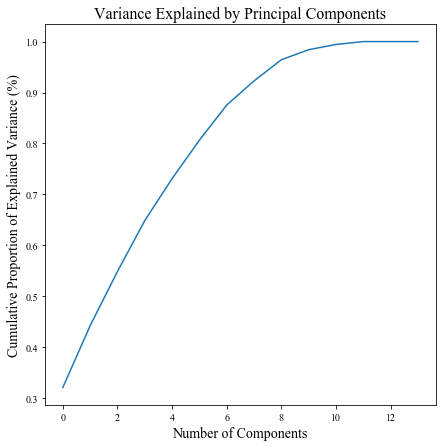

In [310]:
plt.figure(figsize = (7,7))
plt.plot(var1)
plt.xlabel('Number of Components', fontsize = 14)
plt.ylabel('Cumulative Proportion of Explained Variance (%)', fontsize = 14) #for each component
plt.title('Variance Explained by Principal Components', fontsize = 16)
plt.show()

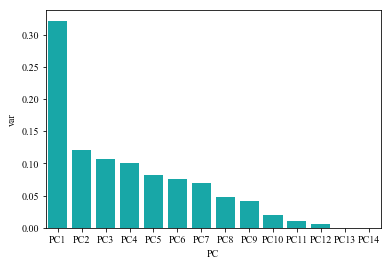

In [311]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PC':['PC1','PC2','PC3','PC4',"PC5", "PC6", "PC7", "PC8","PC9", "PC10", "PC11", "PC12", "PC13", "PC14"]})
sns.barplot(x='PC',y="var", 
           data=df, color="c");

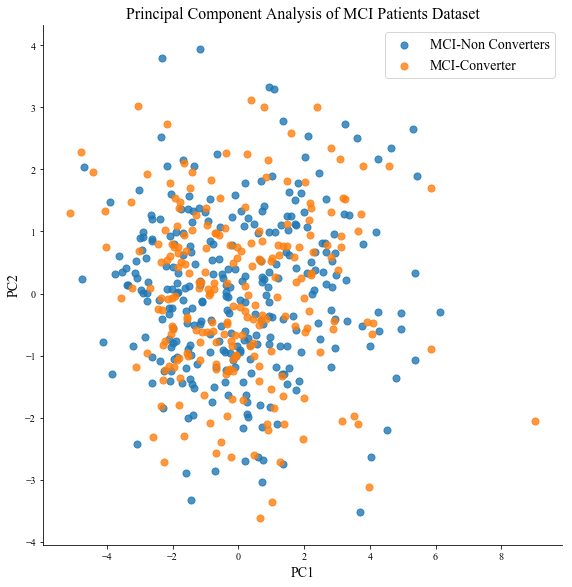

In [354]:
sns.lmplot(x = "PC1", y = "PC2", 
           data = pca_df, fit_reg = False, 
           hue = 'Convert', legend = False, 
           size = 8, scatter_kws = {"s": 50}) 

plt.xlabel("PC1", fontsize = 14)
plt.ylabel("PC2", fontsize = 14)
plt.title("Principal Component Analysis of MCI Patients Dataset",fontsize = 16)
plt.legend(["MCI-Non Converters", "MCI-Converter"], prop = {'size': 14})

# Source = https://cmdlinetips.com/2018/03/pca-example-in-python-with-scikit-learn/